In [1]:
import pandas as pd
import glob
import seaborn as sns
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.corpus import stopwords
from IPython.display import set_matplotlib_formats

#plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["figure.dpi"] = 300

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# plot themes
sns.set_theme(style="whitegrid")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})
sns.axes_style("whitegrid")
set_matplotlib_formats('retina')

%matplotlib inline

/tmp/ipykernel_787/2359945262.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [4]:
## Load data into DataFrame 

In [5]:
path = 'output'
files = glob.glob(path + '/*.csv')

# defining an empty list to store content
jobs_all = pd.DataFrame()
content = []

for filename in files:
    #reading content of csv file
    _df = pd.read_csv(filename, index_col=None)
    content.append(_df)
    
# converting content to data frame
jobs_all = pd.concat(content)

# remove all duplicates jobs
jobs_all = jobs_all.drop_duplicates(subset=['job_id'])
jobs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 0 to 1991
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date_time         1285 non-null   object 
 1   search_keyword    1285 non-null   object 
 2   search_count      1285 non-null   int64  
 3   job_id            1285 non-null   int64  
 4   job_title         1237 non-null   object 
 5   company           1236 non-null   object 
 6   location          1237 non-null   object 
 7   remote            48 non-null     object 
 8   update_time       1014 non-null   object 
 9   applicants        1014 non-null   float64
 10  job_pay           0 non-null      float64
 11  job_time          1237 non-null   object 
 12  job_position      946 non-null    object 
 13  company_size      1237 non-null   object 
 14  company_industry  1140 non-null   object 
 15  job_details       1237 non-null   object 
dtypes: float64(2), int64(2), object(12)
memory

In [6]:
jobs_all.describe(datetime_is_numeric=True)

,search_count,job_id,applicants,job_pay
count,1285.000000,1.285000e+03,1014.000000,0.0
mean,3339.389105,2.698091e+09,14.093688,NaN
std,606.290088,3.976740e+07,21.562236,NaN
min,2463.000000,2.419667e+09,1.000000,NaN
25%,2475.000000,2.697844e+09,3.000000,NaN
50%,3512.000000,2.709764e+09,6.000000,NaN
75%,3859.000000,2.717463e+09,16.000000,NaN
max,3863.000000,2.726247e+09,176.000000,NaN


jobs_all.head(2)

## One month data until 19 September 2021

In [7]:
temp_df = jobs_all.update_time.value_counts() # temp_df is of type pandas Series

#temp_df
temp_df = temp_df[~temp_df.index.str.contains('days ago')]
temp_df = temp_df[~temp_df.index.str.contains('hours ago')]
temp_df = temp_df[~temp_df.index.str.contains('day ago')]
temp_df = temp_df[~temp_df.index.str.contains('hour ago')]
print(temp_df)

this_week_counts = jobs_all.update_time.value_counts().sum(skipna=True) - \
                    temp_df.sum(skipna=True)
print(this_week_counts)
row1 = {'this week': this_week_counts}
df1 = pd.DataFrame(temp_df.items(), columns=['creation time', 'counts'])
df2 = pd.DataFrame(row1.items(), columns=['creation time', 'counts'])

df2 = pd.concat([df2, df1], ignore_index=True)
#job_by_creation_time = pd.concat([pd.DataFrame(temp_df),  df2], ignore_index=True, axis=0)
#job_by_creation_time
df2

2 weeks ago    256
1 week ago     228
3 weeks ago    121
4 weeks ago     17
Name: update_time, dtype: int64
392


,creation time,counts
0,this week,392
1,2 weeks ago,256
2,1 week ago,228
3,3 weeks ago,121
4,4 weeks ago,17


jobs_all.company_industry.value_counts().head(10)

## Job Title

jobs_all.job_title.value_counts().head(10)

In [8]:
# job Position
# Job Postions EDA
# 0 - Internship
# 1 - Entry level
# 2 - Associate
# 3 - Mid-Senior level
# 4 - Director
# 5 - Executive

job_positions = ["Internship", "Entry level", "Associate", "Mid-Senior level", "Director", "Executive"]

jobs_all.job_position.value_counts().head(6)

Entry level         491
Associate           229
Mid-Senior level    187
Executive            31
Internship            8
Name: job_position, dtype: int64

# Analysis

MWETokenizer or 'Multi-Word Expression' Tokenizer takes a string which has aldready been divided into tokens and retokenizes it, merging multi-word expressions into single tokens, using a lexicon of MWEs.  

### Filtering DataFrame

In [9]:
def filtered_df(jobs_all, job_title, job_position):
    # filter the jobs for title (and position)
    jobs_filtered = jobs_all[jobs_all.job_title.str.contains(job_title, na=False)]
    if job_position != "":
        jobs_filtered = jobs_filtered[jobs_filtered.job_position.str.contains(job_position, na=False)]
    
    # create new column for tokenized words
    jobs_filtered['tokenized_details'] = ""
    for index, row in jobs_filtered.iterrows():
        # lowercase words
        detail = row.job_details.lower()
        
        # tokenize words
        detail = word_tokenize(detail)
        # handle multi-word tokenization (e.g., Power BI)
        tokenizer = MWETokenizer([('power', 'bi'), ('scala', 'sucks')])
        detail = tokenizer.tokenize(detail)
        # remove duplicates
        detail = list(set(detail))
        #print('removed duplicates ', detail)
        # remove stopwords & numbers/punction
        detail = [word for word in detail if word not in stopwords.words('english')] 
        # add to details list
        #print('removed stopwords, number, punctuation: ', detail)
        #row.tokenized_details = detail
        jobs_filtered.at[index,'tokenized_details'] = detail
        #print('\ntokenized row: ', row.tokenized_details)
    
    return jobs_filtered

### Wordcloud of keywords

In [10]:
def word_cloud(jobs_filtered, keywords):
    #print('cloud before ', jobs_filtered.tokenized_details)
    # convert df column to list
    analyst_list = jobs_filtered.tokenized_details.tolist()
    #print('conver column to list ', analyst_list)
    # flatten list of lists
    analyst_list = [item for sublist in analyst_list for item in sublist]
    #print(analyst_list)
    # filter list
    #analyst_list = [item for item in analyst_list if item in keywords]
    analyst_list = [item for item in analyst_list if item in keywords]
    # convert for wordcloud
    analyst_list = " ".join(words for words in analyst_list)
    #print('wordcloud conversion ', analyst_list)
    # wordcloud the results
    #fig, ax = plt.figure(figsize=(10,7))
    wc_join = WordCloud(background_color="white", collocations=False).generate(analyst_list)
    plt.imshow(wc_join, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return

### Bar chart of keywords

In [11]:
def filtered_keywords(jobs_filtered, keywords, title="Keyword Analysis", head=10):
    # get keywords in a column
    count_keywords = pd.DataFrame(jobs_filtered.tokenized_details.sum()).value_counts().rename_axis('keywords').reset_index(name='counts')
    #count_keywords = count_keywords.set_index('keywords')

    # get frequency of occurence of word (as word only appears once per line)
    length = len(jobs_filtered) # number of job postings
    count_keywords['percentage'] = 100 * count_keywords.counts / length

    # plot the results
    count_keywords = count_keywords[count_keywords.keywords.isin(keywords)]
    count_keywords = count_keywords.head(head)
    g = sns.barplot(x="keywords", y="percentage", data=count_keywords)
    g.set_xticklabels(g.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')
    plt.xlabel("")
    plt.ylabel("Likelyhood to be in job posting (%)")
    plt.title(title) 
    plt.show(g)
    print(count_keywords)

In [12]:
# went through and picked out the keywords
keywords_analyst = ['excel', 'sql', 'microsoft', 'tableau',  'python', 'word',
'powerpoint', 'r',  'slack', 'coding', 'looker', 'hadoop', 
'outlook', 'azure', 'jira', 'twilio', 'server', 'snowflake', 'ai', 'warehousing', 'scrum',
'powerbi', 'shell', 'linux', 'sas', 'sharepoint', 'devops', 'mysql', 'c', 'visio', 
'javascript', 'git', 'mssql', 'vba', 'powerpoints', 'java', 'postgresql', 'spreadsheets',
'pandas', 'gdpr', 'elt', 'scala', 'css', 'spreadsheet', 'alteryx', 'github', 'postgres', 'power_bi', 'spss']

# common terms removed for graphing
# removed = ['power', 'database', 'cloud', 'saas', 'programming', 'etl', 'bi', ]





## Data Scientist

In [13]:
scientist_entry = filtered_df(jobs_all, "Scientist", "Entry level")

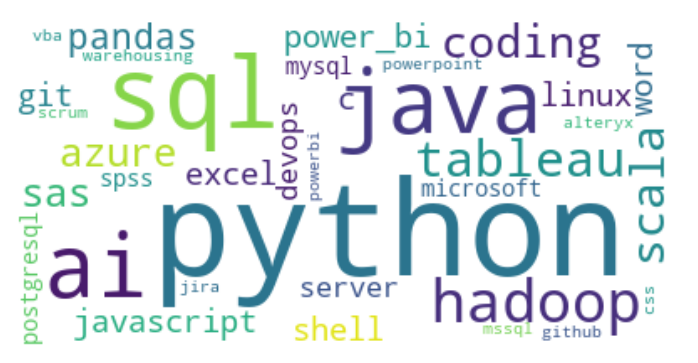

In [14]:
word_cloud(scientist_entry, keywords_analyst)

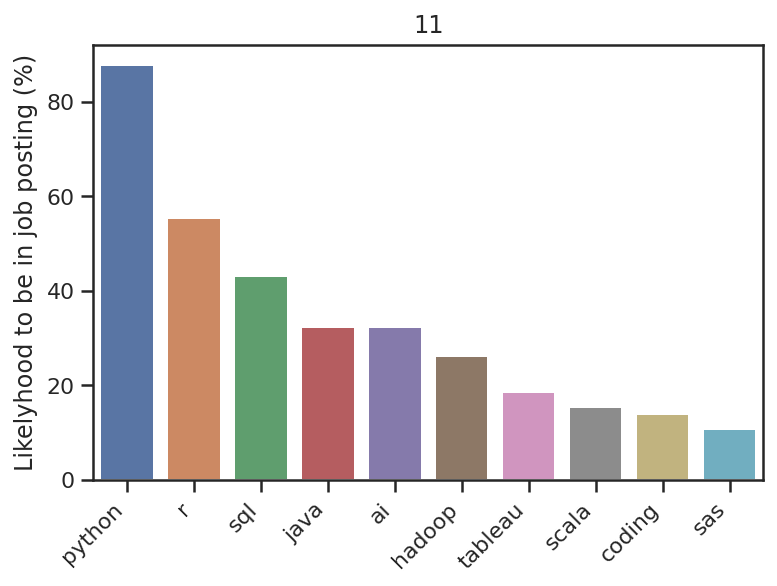

    keywords  counts  percentage
6     python      57   87.692308
37         r      36   55.384615
57       sql      28   43.076923
107     java      21   32.307692
115       ai      21   32.307692
150   hadoop      17   26.153846
242  tableau      12   18.461538
283    scala      10   15.384615
304   coding       9   13.846154
411      sas       7   10.769231


In [15]:

filtered_keywords(scientist_entry, keywords_analyst, 11)

## Data Analyst

In [16]:
analyst_entry = filtered_df(jobs_all, "Analyst", "Entry level")
analyst_entry.head(5)

,date_time,search_keyword,search_count,job_id,job_title,company,location,remote,update_time,applicants,job_pay,job_time,job_position,company_size,company_industry,job_details,tokenized_details
16,19Sep2021-15:21:10,data analyst,3857,2720418432,Data Analyst (SQL/Tableau),Experis Singapore,"Singapore, Singapore",NaN,1 week ago,1.0,NaN,Full-time,Entry level,51-200 employees,Staffing & Recruiting,Basic Information One of the largest game publ...,"[job, data, (, sen, visit, hour, game, familia..."
21,19Sep2021-15:21:50,data analyst,3857,2718716720,Risk Data Analyst,Shopee,"Singapore, Singapore",NaN,1 day ago,8.0,NaN,Full-time,Entry level,"5,001-10,000 employees",Internet,Job Description Perform rigorous analysis on t...,"[segmentation, job, data, (, minimum, clear, u..."
23,19Sep2021-15:22:01,data analyst,3857,2718717639,Risk Data Analyst,Shopee,"Singapore, Singapore",NaN,1 day ago,23.0,NaN,Full-time,Entry level,"5,001-10,000 employees",Internet,Job Description Work with big data using the H...,"[job, data, fast-paced, teams, strive, higher,..."
30,19Sep2021-15:23:19,data analyst,3857,2720006280,Data Analyst #TeSA,Singtel,"Singapore, Singapore",NaN,NaN,NaN,NaN,Full-time,Entry level,"10,001+ employees",Telecommunications,"Singtel, Asia’s leading communications technol...","[job, africa, data, singtel, (, innovate, *, d..."
31,19Sep2021-15:23:25,data analyst,3857,2707846569,Data Analyst (132309),Singtel,"Singapore, Singapore",NaN,1 week ago,12.0,NaN,Full-time,Entry level,"10,001+ employees",Telecommunications,"At Singtel, we believe in the strength of a vi...","[model, manipulation, self-starter, data, sing..."


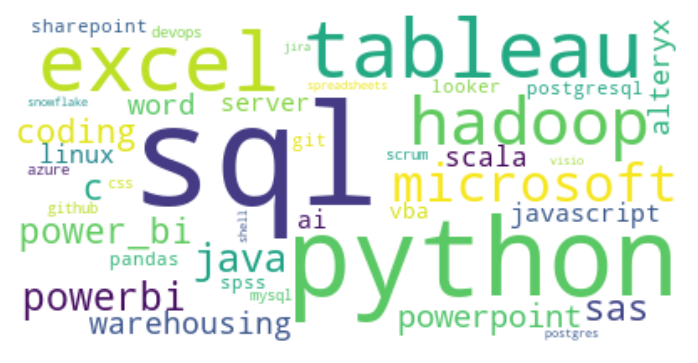

In [17]:
word_cloud(analyst_entry, keywords_analyst)

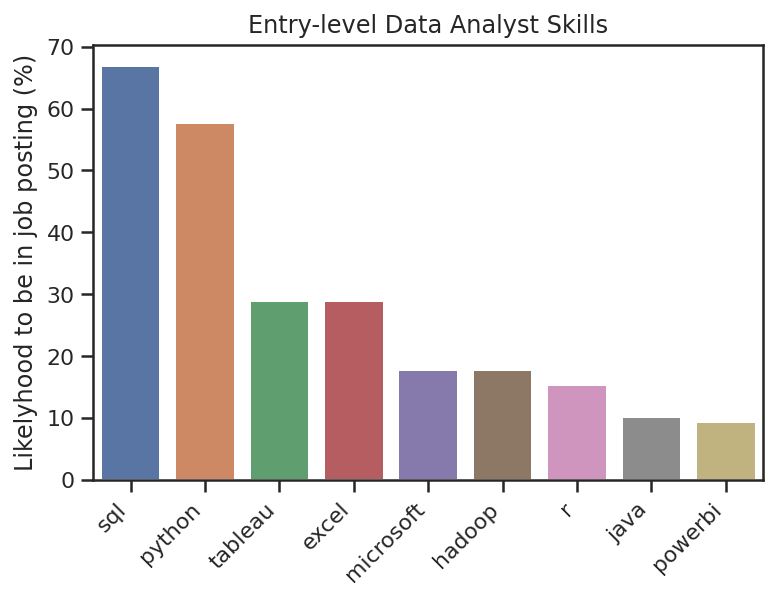

      keywords  counts  percentage
15         sql      79   66.949153
20      python      68   57.627119
91     tableau      34   28.813559
93       excel      34   28.813559
188  microsoft      21   17.796610
192     hadoop      21   17.796610
223          r      18   15.254237
382       java      12   10.169492
442    powerbi      11    9.322034


In [18]:
filtered_keywords(analyst_entry, keywords_analyst, "Entry-level Data Analyst Skills", 9)

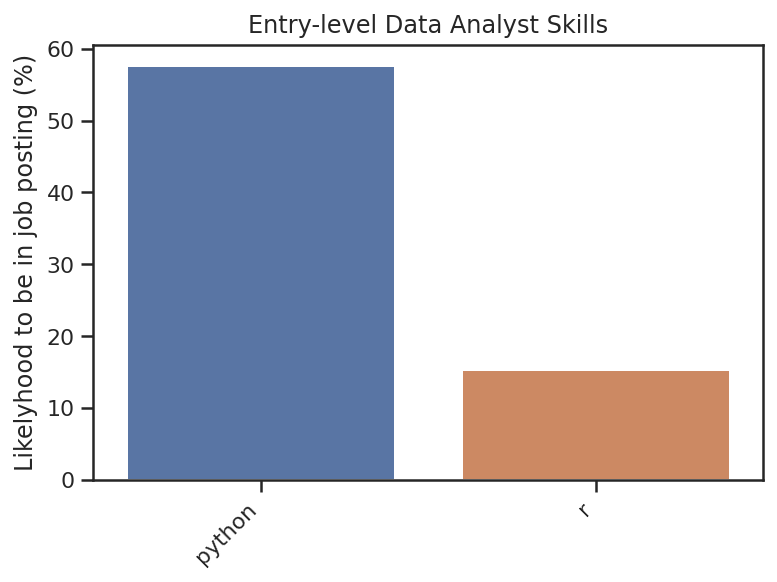

    keywords  counts  percentage
20    python      68   57.627119
223        r      18   15.254237


In [19]:
python_r = ["python", "r"]
filtered_keywords(analyst_entry, python_r, "Entry-level Data Analyst Skills")

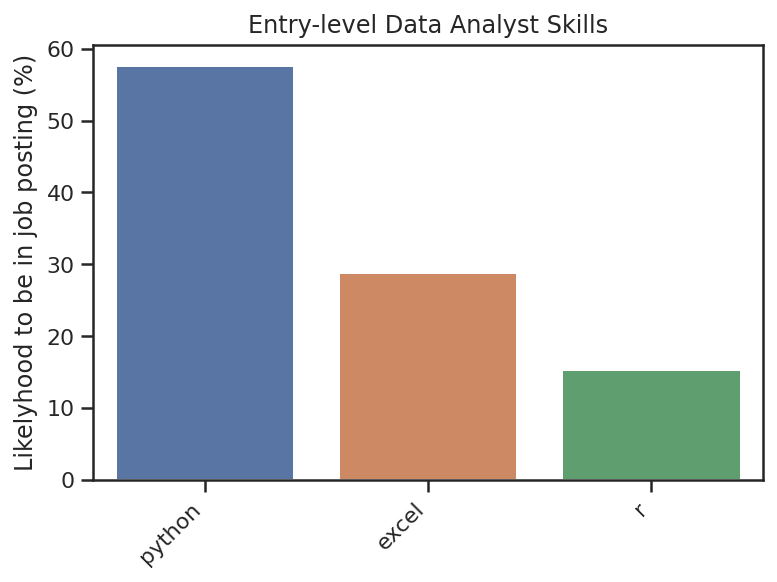

    keywords  counts  percentage
20    python      68   57.627119
93     excel      34   28.813559
223        r      18   15.254237


In [20]:
excel_python_r = ["python", "r", "excel"]
filtered_keywords(analyst_entry, excel_python_r, "Entry-level Data Analyst Skills")

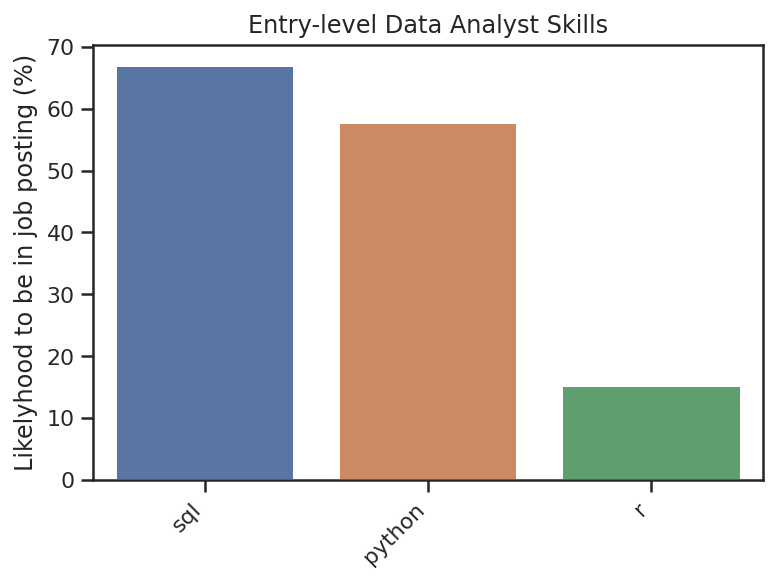

    keywords  counts  percentage
15       sql      79   66.949153
20    python      68   57.627119
223        r      18   15.254237


In [21]:
sql_python_r = ["sql", "r", "python"]
filtered_keywords(analyst_entry, sql_python_r, "Entry-level Data Analyst Skills")

## Data Analyst Non-Entry 

In [22]:
non_entry = ["Associate", "Mid-Senior level", "Director", "Executive"]

analyst_nonentry = pd.DataFrame()
for entry in non_entry:
    analyst_nonentry = analyst_nonentry.append(filtered_df(jobs_all, "Analyst", entry))

len(analyst_nonentry)

137

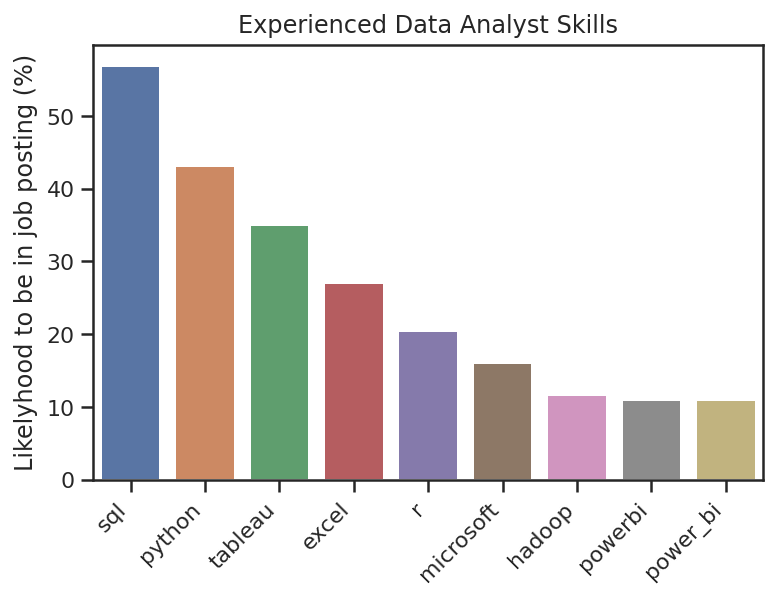

      keywords  counts  percentage
14         sql      78   56.934307
38      python      59   43.065693
61     tableau      48   35.036496
102      excel      37   27.007299
155          r      28   20.437956
221  microsoft      22   16.058394
353     hadoop      16   11.678832
373    powerbi      15   10.948905
406   power_bi      15   10.948905


In [23]:
filtered_keywords(analyst_nonentry, keywords_analyst, "Experienced Data Analyst Skills", 9)

## Entry level Engineer

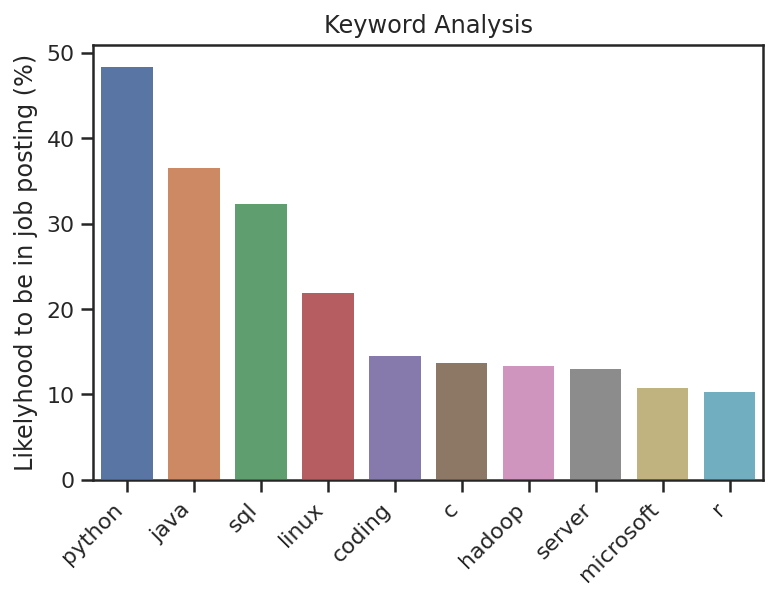

      keywords  counts  percentage
33      python     130   48.507463
63        java      98   36.567164
81         sql      87   32.462687
161      linux      59   22.014925
268     coding      39   14.552239
284          c      37   13.805970
300     hadoop      36   13.432836
311     server      35   13.059701
391  microsoft      29   10.820896
413          r      28   10.447761


In [24]:
engineer_entry = filtered_df(jobs_all, "Engineer", "Entry level")
filtered_keywords(engineer_entry, keywords_analyst)

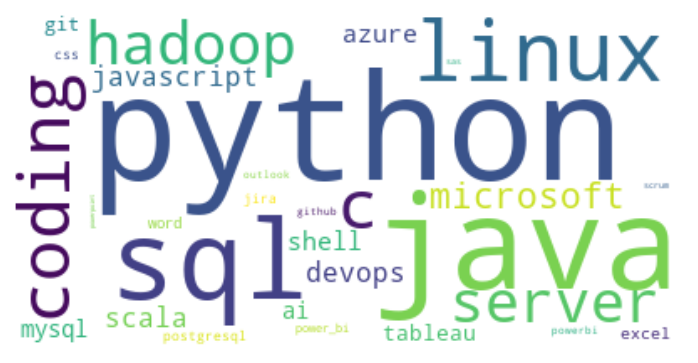

In [25]:
word_cloud(engineer_entry, keywords_analyst)